In [1]:
import numpy as np

import sys
from parallel import Parallel

sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt
sys.path.append('../../analyz')
from analyz.signal_library.stochastic_processes import OrnsteinUhlenbeck_Process
from analyz.processing.signanalysis import autocorrel, crosscorrel

 /!\  "svgutils" not installed ! get it with: "pip install svgutils" 


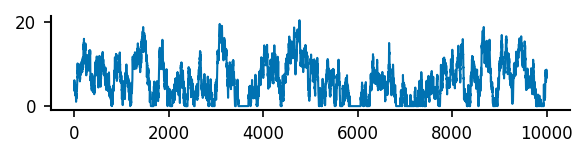

In [2]:
mean, sigma, tau = 5, 5, 10
tstop = 1000
dt = 0.1
OU = np.clip(OrnsteinUhlenbeck_Process(mean, sigma, tau, dt, tstop), 0, np.inf)

fig, ax = pt.figure(figsize=(2,1))
ax.plot(OU)

In [3]:
print(1e3*len(results['spikes'])/results['tstop'])

NameError: name 'results' is not defined

15.7


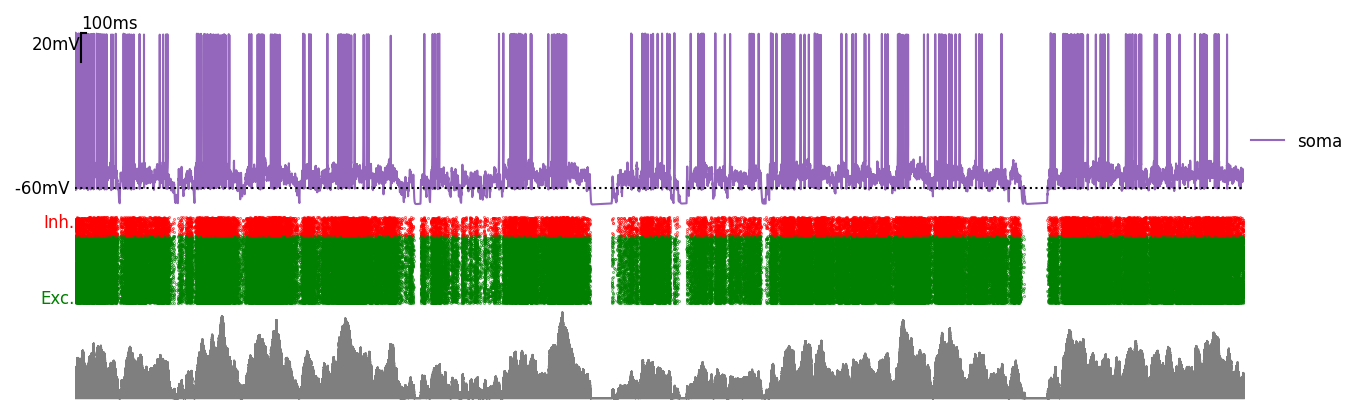

In [12]:
results = np.load('../../data/detailed_model/demo-tvRate-Martinotti.npy', allow_pickle=True).item()

t = np.arange(len(results['Vm_soma']))*results['dt']
fig, AX = pt.figure(axes_extents=[[(1,2)],[(1,1)],[(1,1)]],
                    figsize=(3,1), left=0, bottom=0., hspace=0.)
AX[0].plot(t, results['Vm_soma'], 'tab:purple', label='soma')
AX[0].plot(t, -60+0*t, 'k:')
pt.annotate(AX[0], '-60mV ', (0,-60), xycoords='data', ha='right', va='center')
pt.draw_bar_scales(AX[0], Xbar=100, Xbar_label='100ms', Ybar=20, Ybar_label='20mV')
AX[0].legend(frameon=False, loc=(1, 0.3))

for i, events in enumerate(results['presynaptic_exc_events']):
    AX[1].plot(events, i*np.ones(len(events)), '.', color='g', ms=.5)
for i, events in enumerate(results['presynaptic_inh_events']):
    AX[1].plot(events, len(results['presynaptic_exc_events'])+i*np.ones(len(events)), '.', 
               color='r', ms=.5)
pt.annotate(AX[1], 'Inh.', (0,1), ha='right', va='top', color='r')
pt.annotate(AX[1], 'Exc.', (0,0), ha='right', va='bottom', color='g')

AX[2].fill_between(t[:-1], 0*t[:-1], results['OU'], color='tab:grey')
#AX[2].fplot(t[:1], results['OU'], color='tab:grey')

pt.set_common_xlims(AX, lims=[t[0], t[-1]])
for ax in AX:
    ax.axis('off')

print(1e3*len(results['spikes'])/results['tstop'])

(-1000.0, 1000.0)

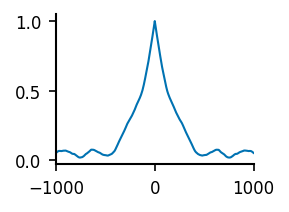

In [10]:
CCF, ts = crosscorrel(results['OU'][::4], results['OU'][::4], 1e3, 4*results['dt'])
plt.plot(ts, CCF)
plt.xlim([-1000,1000])

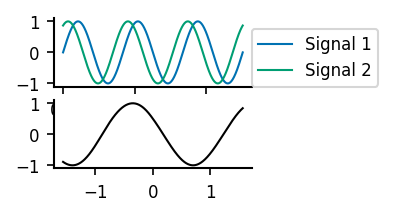

In [51]:
t = np.linspace(0, np.pi*2, int(1000))
Signal1 = np.sin(3*t)
Signal2 = np.cos(3*t-np.pi/6)
_, ax = plt.subplots(2)
ax[0].plot(t, Signal1, label='Signal 1')
ax[0].plot(t, Signal2, label='Signal 2')
ax[0].legend(loc=(1,0))
cr, t_shift = crosscorrel(Signal1, Signal2, np.pi/2., t[1]-t[0])
ax[1].plot(t_shift, cr, 'k-')

In [15]:
sim = Parallel(\
        filename='../../data/detailed_model/tvRateStim_sim_Basket.zip')
sim.load()

In [16]:
sim.fetch_quantity_on_grid('Vm_soma', dtype=list)


In [18]:
sim.Vm_soma

array([[array([-70.        , -70.00053693, -70.00093526, ..., -55.82550552,
               -55.85195786, -55.87918416])                                ,
        array([-70.        , -70.00053693, -70.00093526, ..., -54.05650939,
               -54.07717521, -54.10052378])                                ,
        array([-70.        , -70.00053693, -70.00093526, ..., -54.5600905 ,
               -54.60723223, -54.64536896])                                ,
        array([-70.        , -70.00053693, -70.00093526, ..., -60.6804234 ,
               -60.6747424 , -60.6692662 ])                                ,
        array([-70.        , -70.00053693, -70.00093526, ..., -55.51869345,
               -55.51091046, -55.50561542])                                ,
        array([-70.        , -70.00053693, -70.00093526, ..., -49.68205177,
               -49.67934858, -49.6760808 ])                                ,
        array([-70.        , -70.00053693, -70.00093526, ..., -56.02306323,
      

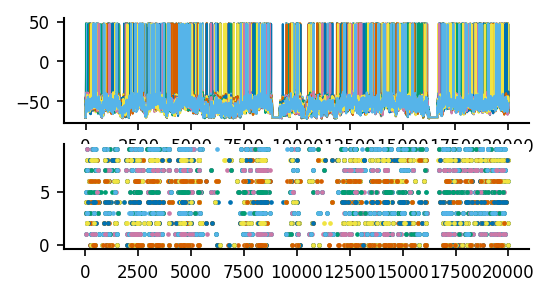

In [53]:
def find_spikes(t, Vm, threshold=0):

    iSpikes = np.argwhere((Vm[1:]>threshold) & (Vm[:-1]<=threshold))
    
    return t[iSpikes]

Spikes = []
fig, AX = plt.subplots(2, figsize=(4,2))
dt = sim.fetch_quantity_on_grid('dt', return_last=True)
for Vms in sim.Vm_soma:
    for i, vm in enumerate(Vms):
        t = np.arange(len(vm))*dt
        spikes = find_spikes(t, vm)
        AX[0].plot(t, vm)
        AX[1].plot(spikes, i+0*spikes, '.')
        Spikes.append(spikes)

In [54]:
spikes_matrix= np.zeros((len(Spikes), int(tstop/dt)+1))
for i, spikes in enumerate(Spikes):
    spikes_matrix[i,(spikes/dt).astype('int')] = True

In [55]:
from scipy.ndimage import gaussian_filter1d
smoothing = 5.
rate = 1e3*gaussian_filter1d(np.mean(spikes_matrix, axis=0)/dt, int(smoothing/dt))
np.mean(rate)

7.0741578239693865

In [56]:
tstop = sim.fetch_quantity_on_grid('tstop', return_last=True)


In [57]:
OU = sim.fetch_quantity_on_grid('OU', return_last=True, dtype=np.ndarray)

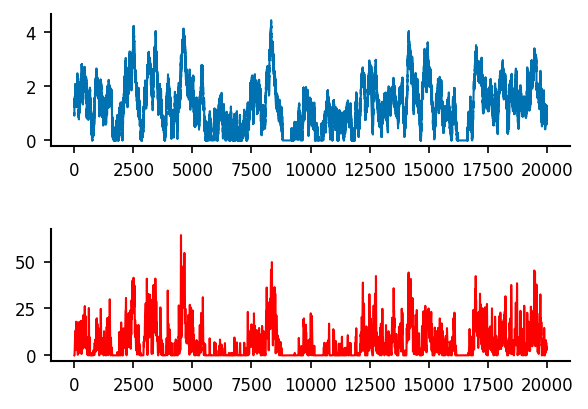

In [58]:
fig, AX = pt.figure(axes=(1,2), figsize=(2,1.4))
AX[0].plot(t[:-1], OU)
AX[1].plot(t, rate, 'r')

(-1000.0, 1000.0)

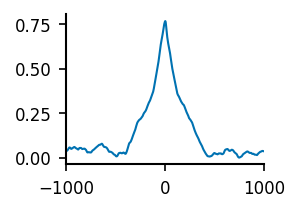

In [59]:
CCF, ts = crosscorrel(OU[::4], rate[1:][::4], 1e3, 4*dt)
plt.plot(ts, CCF)
plt.xlim([-1000,1000])